# Практика по PyTorch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [29]:
matplotlib.rcParams['figure.figsize'] = (25.0, 10.0)
%matplotlib inline

torch.manual_seed(1)
torch.set_num_threads(12)
print('Threads:', torch.get_num_threads())

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(DEVICE)

Threads: 12
cpu


## Определения

In [24]:
def f_(x, y):
    return torch.sin(x + 2 * y) * torch.exp(-torch.pow((2 * x + y), 2))

def f(x, y):
    return torch.sin(y) + torch.cos(x) # * torch.exp(-torch.pow((2 * x + y), 2))

def getRandVector(n):
    v = torch.rand(n, dtype=torch.float16)
    return v * 20.0 - 10.0

## Dataset

In [30]:
n = 5000 #20000 # Размер выборки

X = torch.stack((getRandVector(n), getRandVector(n)), dim=1)
y = f(X[:, 0], X[:, 1])
y.unsqueeze_(1)
X.to(DEVICE)
y.to(DEVICE)

print(X)
print(y)

tensor([[ 0.3594,  3.6719],
        [-7.7031,  5.1953],
        [ 8.8750, -2.8125],
        ...,
        [ 7.1875,  5.2812],
        [ 0.8125, -8.7109],
        [-0.6875,  4.3281]], dtype=torch.float16)
tensor([[ 0.4302],
        [-0.7354],
        [-1.1758],
        ...,
        [-0.2241],
        [ 0.0327],
        [-0.1543]], dtype=torch.float16)


Text(0.5, 0, 'f(x, y)')

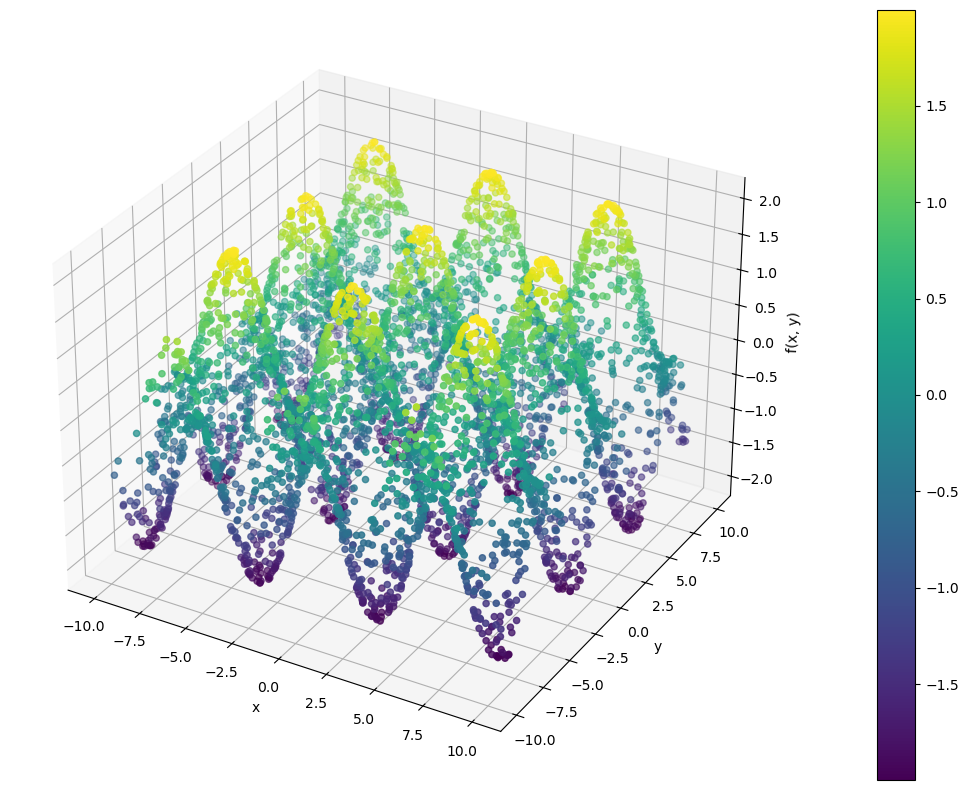

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dia = ax.scatter(X[:,0].numpy(), X[:,1].numpy(), y.detach().numpy(), c=y.detach().numpy(), cmap="viridis")
fig.colorbar(dia)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')

## Split dataset to train/test/val
Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

## Определяем модель

In [16]:
class RegressionModel(nn.Module):
    def __init__(self, hidden_size, post_size = 200):
        super(RegressionModel, self).__init__()

        self.fc1 = nn.Linear(2, hidden_size)
        self.act1 = torch.nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, 1)


    def normalizeInput(self, x):
        # Normalization to range [-1; 1]
        return x / 10


    def forward(self, x):
        x = self.normalizeInput(x)
        x = self.act1(self.fc1(x))
        x = self.fc2(x)
        return x
    

    def getMetric(model, X_val, y_val):
        y_val_pred = model.forward(X_val)
    
        mse = mean_squared_error(y_val_pred.detach().numpy(), y_val.detach().numpy()) 
        return mse
    

# если метрика не улучшилась больше чем на level% на протяжении последних 5ти эпох, 
# то нейросеть уже дошла до своего предела, так считаем, и останавливаем обучение сети.
# verbose_only — параметр для отладки, когда выводится информация, а реальной остановки не делается
def isStop(mse_list, level=0.005, mseLevel=0.001, verbose_only=False):
    if len(mse_list) >= 5 and mse_list[-1] <= mseLevel:
        n = 4
        events = 0

        if verbose_only:
            print('——————————————')
    
        for i in range(-n - 1, -1):
                if abs(mse_list[-1] - mse_list[i]) / mse_list[i] < level:
                    if verbose_only:
                        print(mse_list[-1], mse_list[i], abs(mse_list[-1] - mse_list[i]) / mse_list[i])
                    else:
                        events = events + 1
        
        if events == n:
            return True
        
    return False

## Тренируем модель

100%|██████████| 3000/3000 [00:04<00:00, 728.45it/s]


Обучение нейронной сети завершено.
MSE по валидац. выборке: 0.003


Text(0.5, 0, 'y_pred')

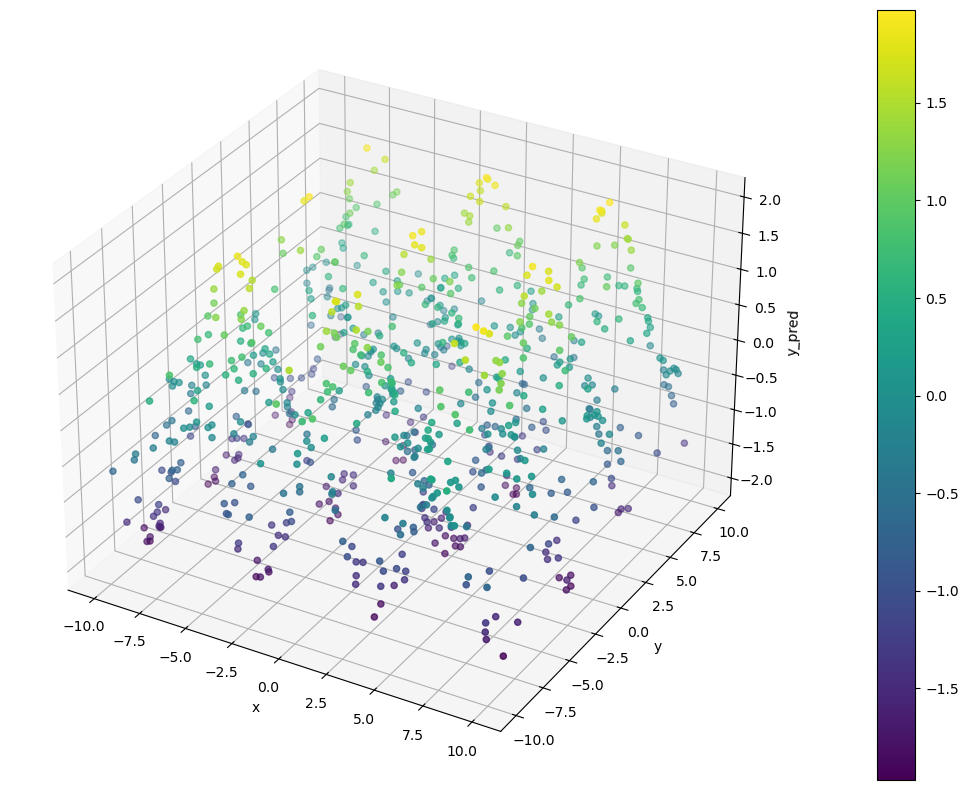

In [27]:
num_epochs = 3000 # Число эпох
stopLevel = 0.002 # Критерий остановки обучения
mseLevel = 0.001 # Требуемый уровень ошибки MSE

model = RegressionModel(15)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) # lr=0.01

mse_list = []
for epoch_index in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    mse_list.append(model.getMetric(X_val, y_val))

    #if epoch_index % 300 == 0:
    #isStop(mse_list, level=stopLevel, verbose_only=True)

    if isStop(mse_list, level=stopLevel, mseLevel = mseLevel):
        break

print('Обучение нейронной сети завершено.')
print("MSE по валидац. выборке: {:.3f}".format(model.getMetric(X_val, y_val)))

y_pred = model.forward(X_val)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dia = ax.scatter(X_val[:, 0].numpy(), X_val[:, 1].numpy(), y_pred.detach().numpy(), c=y_pred.detach().numpy(), cmap="viridis")
fig.colorbar(dia)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('y_pred')

## Проверяем результат

MSE по тестовой выборке: 0.003


Text(0.5, 0, 'y_pred')

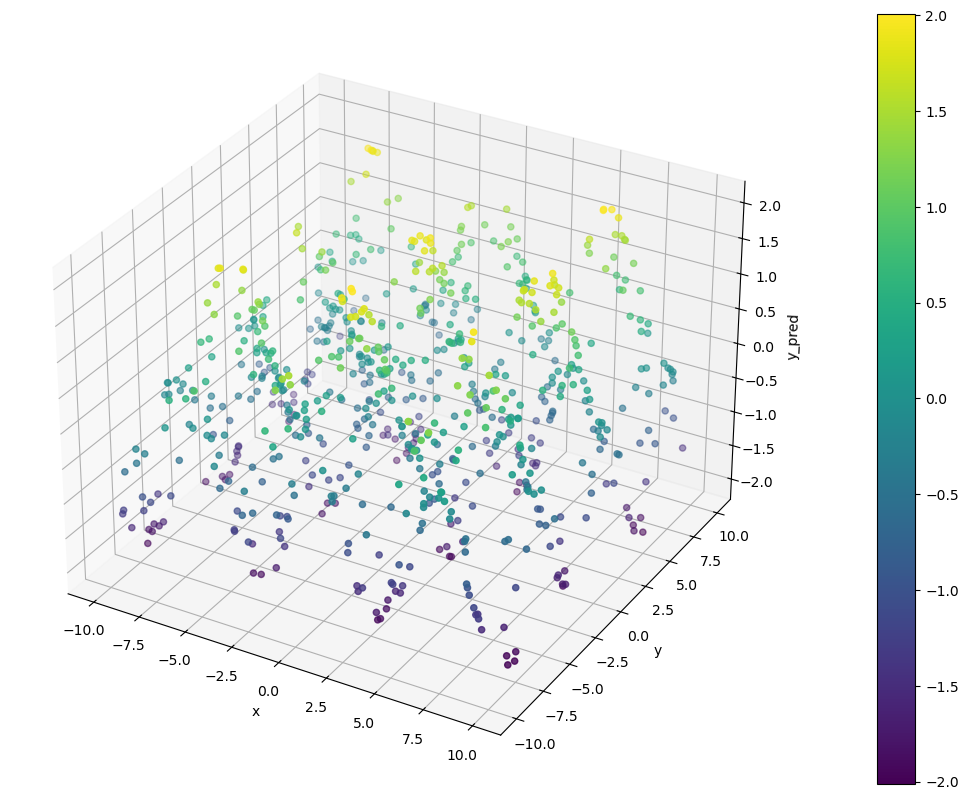

In [28]:

model.eval() # Переводим модель в режим inference

print("MSE по тестовой выборке: {:.3f}".format(model.getMetric(X_test, y_test)))

y_pred = model.forward(X_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dia = ax.scatter(X_test[:, 0].numpy(), X_test[:, 1].numpy(), y_pred.detach().numpy(), c=y_pred.detach().numpy(), cmap="viridis")
fig.colorbar(dia)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('y_pred')
